In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from numpy import mean
import matplotlib  as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns; sns.set_style("white")

In [2]:
project = 'SSS-val-v2'

In [3]:
OutputDir = input("Enter name for output folder: ")  
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)

Enter name for output folder:  Results


In [4]:
df = pd.read_feather('datasetForPLS-DA.feather')
dfContr = df[df['batch_id'].isin(['DMSO', 'non-inf'])].copy() # select DMSO wells with infected and noninfected cells
dfContr.reset_index(inplace=True, drop=True)

In [5]:
dfContr.head(1)

,Metadata_Barcode,Metadata_Well,comp_conc,pert_type,batch_id,pert_iname,cmpd_conc,cbkid,Count_nuclei,AreaShape_Area_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
0,P103554,A08,non-inf_0.3,non-inf,non-inf,non-inf,0.3,CBK281357,323.0,2.411108,...,-0.395238,0.444852,-0.088016,0.269279,-0.21653,-0.387594,-0.062359,-0.250965,-0.410259,0.158948


In [6]:
clip = float('inf') # if we want to clip extreme values; otherwise float('inf')
x = dfContr.iloc[:,9:]
x.clip(lower = -clip, upper = clip, inplace=True)
y = np.where(dfContr['pert_type'] == 'negcon', 0, 1)
pls2 = PLSRegression(n_components=2, scale=False)
pls2.fit(x, y)

# calculate R² value
r2 = pls2.score(x, y)
print(f'R²: {r2:.3f}')

# cross-validation
Q2 = cross_val_score(pls2, x, y, cv=5, scoring='r2')
q2_mean = mean(Q2)
print(f'Q²: {q2_mean:.3f}')

roc_auc = cross_val_score(pls2, x, y, cv=5, scoring='roc_auc')
roc_auc_mean = mean(roc_auc)
print(f'ROC AUC: {roc_auc_mean:.3f}')

scores = pls2.x_scores_
scoreDf = pd.DataFrame(data = scores)
scoreDf.rename(columns={0: 'PC1', 1: 'PC2'}, inplace=True)
scoreDf = pd.concat([scoreDf, dfContr.iloc[:, :7]], axis=1)
scoreDf

R²: 0.973
Q²: 0.969
ROC AUC: 1.000


,PC1,PC2,Metadata_Barcode,Metadata_Well,comp_conc,pert_type,batch_id,pert_iname,cmpd_conc
0,-32.351431,-7.046056,P103554,A08,non-inf_0.3,non-inf,non-inf,non-inf,0.3
1,33.354781,-6.518026,P103554,A12,DMSO_0.3,negcon,DMSO,DMSO,0.3
2,-28.523442,-10.765494,P103554,A16,non-inf_0.3,non-inf,non-inf,non-inf,0.3
3,31.290156,-0.873889,P103554,A21,DMSO_0.3,negcon,DMSO,DMSO,0.3
4,29.006298,-8.934330,P103554,B07,DMSO_0.3,negcon,DMSO,DMSO,0.3
...,...,...,...,...,...,...,...,...,...
1284,42.014903,-13.352991,P103573,O20,DMSO_0.3,negcon,DMSO,DMSO,0.3
1285,10.706846,37.575517,P103573,P03,DMSO_0.3,negcon,DMSO,DMSO,0.3
1286,-48.446211,41.151383,P103573,P08,non-inf_0.3,non-inf,non-inf,non-inf,0.3
1287,31.476115,-0.389602,P103573,P14,DMSO_0.3,negcon,DMSO,DMSO,0.3


In [7]:
loadings = pls2.x_loadings_
loadingDf = pd.DataFrame(data = loadings, index = x.columns)
loadingDf.rename(columns={0: 'PC1', 1: 'PC2'}, inplace=True)
loadingDf.sort_values('PC1', inplace=True)
loadingDf

,PC1,PC2
Neighbors_PercentTouching_Adjacent_cells,-0.082699,0.032207
RadialDistribution_MeanFrac_illumMITO_2of4_cytoplasm,-0.079510,-0.048116
RadialDistribution_MeanFrac_illumMITO_1of4_cells,-0.078735,-0.085652
AreaShape_Zernike_0_0_cytoplasm,-0.069492,-0.030584
AreaShape_FormFactor_cytoplasm,-0.068933,-0.033699
...,...,...
Correlation_Manders_illumSYTO_illumHOECHST_cells,0.074671,0.048213
Correlation_Overlap_illumMITO_illumPHAandWGA_nuclei,0.081535,0.131014
Correlation_Overlap_illumMITO_illumPHAandWGA_cytoplasm,0.094975,0.055053
Correlation_RWC_illumSYTO_illumHOECHST_cells,0.095329,0.039481


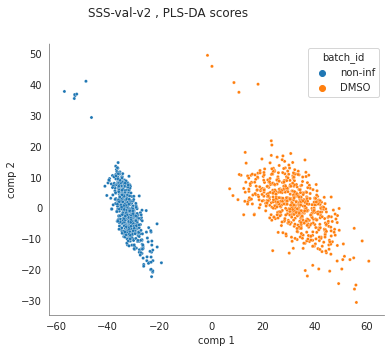

In [8]:
fig = plt.figure(figsize = (6,5))
fig.suptitle(f'{project} , PLS-DA scores', fontsize = 12, x=0.4)
ax = fig.add_subplot(111) 
ax.set_xlabel('comp 1', fontsize = 10)
ax.set_ylabel('comp 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax =sns.scatterplot(x='PC1', y='PC2',  
                  data=scoreDf, hue = 'batch_id',
                   s=10, alpha = 1,  marker = 'o');

ax.set_facecolor('w')
fig.savefig(f'{OutputDir}/PLS-DA_scores.png',  dpi=150, bbox_inches='tight')
plt.show()

In [9]:
PLS_pred = pls2.predict(x)
PLS_pred = pd.DataFrame(PLS_pred, columns = ['PLS_pred'])
PLS_pred = pd.concat([PLS_pred, dfContr.iloc[:, :5]], axis=1)
PLS_pred.reset_index(inplace=True)

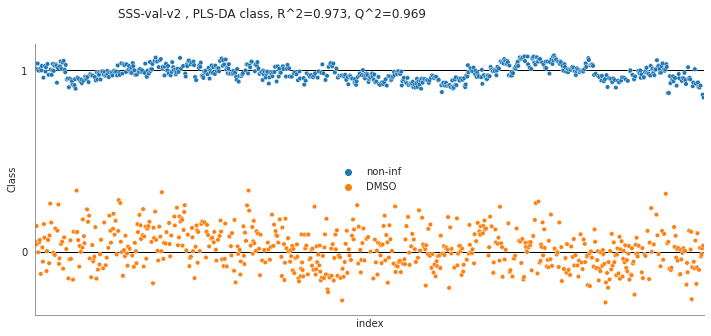

In [10]:
fig = plt.figure(figsize = (12,5))
fig.suptitle(f'{project} , PLS-DA class, R^2={r2:.3f}, Q^2={q2_mean:.3f}', fontsize = 12, x=0.4)
ax = fig.add_subplot(111) 
ax.set_xlabel('index', fontsize = 10)
ax.set_ylabel('Class', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax =sns.scatterplot(x='index', y='PLS_pred',  
                  hue='batch_id', data=PLS_pred,
                    #palette=colors,
                    s=20, alpha = 1,  marker = 'o');

ax.set_facecolor('w')

ax.set_yticks([0, 1])
ax.grid(visible=True, which='major', axis='y', color='black', linestyle='-', linewidth=1, alpha = 1)
ax.tick_params(axis='x', labelbottom=False)
ax.set_xlim([0, PLS_pred.shape[0]])
ax.legend(frameon=False)
fig.savefig(f'{OutputDir}/PLS-DA_scatter.png',  dpi=150, bbox_inches='tight')
plt.show()

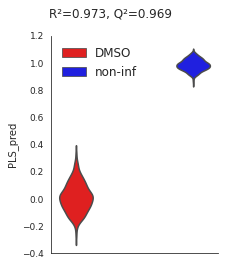

In [11]:
PLS_pred.sort_values('batch_id', inplace=True, )

fig = plt.figure(figsize = (3,4))
fig.suptitle(f'R²={r2:.3f}, Q²={q2_mean:.3f}', fontsize = 12, x=0.4)
#plt.rcParams.update({'axes.titlesize': 'small'})
ax = fig.add_subplot(111)
ax =sns.violinplot(x='batch_id', y='PLS_pred',scale = 'count', inner = None, 
              hue='batch_id', data=PLS_pred, palette=['red',  'blue'], s=1, alpha = 0.2, marker = 'o');
ax.legend(fontsize = 12, frameon = False, loc = 2)

ax.set_ylim([-0.4, 1.2])
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.axes.get_xaxis().set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=9)
sns.despine()
fig.savefig('{}/PLS-DA_violin.{}'.format(OutputDir, 'pdf'),  dpi=300)

In [12]:
x_all = df.iloc[:,9:].copy()
x_all.clip(lower  =-clip, upper = clip, inplace=True)
PLS_pred_all = pls2.predict(x_all)
PLS_pred_all = pd.DataFrame(PLS_pred_all, columns = ['PLS_pred'])
PLS_pred_all = pd.concat([df.iloc[:, :9], PLS_pred_all], axis=1)
PLS_pred_all.to_csv(f'{OutputDir}/PLS_predictions.csv', sep=';',  float_format='%.3f')
PLS_pred_all.head(1)

,Metadata_Barcode,Metadata_Well,comp_conc,pert_type,batch_id,pert_iname,cmpd_conc,cbkid,Count_nuclei,PLS_pred
0,P103554,A02,BJ1894548_0.3,trt,BJ1894548,chloroquine,0.3,CBK017143,281.0,0.249281


In [13]:
pred_per_comp_conc_Mean = PLS_pred_all[['batch_id', 'pert_iname', 'cmpd_conc', 'Count_nuclei', 'PLS_pred', 'cbkid']].groupby(by=['batch_id', 'pert_iname', 'cbkid', 'cmpd_conc']).agg(['mean']) # add 'std' or 'median'?
pred_per_comp_conc_Mean.columns = ["_".join(a) for a in pred_per_comp_conc_Mean.columns.to_flat_index()]
pred_per_comp_conc_Mean.reset_index(inplace=True)
pred_per_comp_conc_Mean.tail()

,batch_id,pert_iname,cbkid,cmpd_conc,Count_nuclei_mean,PLS_pred_mean
1289,[etop],Etoposide,[etop],5.0,174.494152,-0.049891
1290,[fenb],Fenbendazole,[fenb],5.0,127.445927,0.006182
1291,[flup],Fluphenazine,[flup],5.0,268.267982,0.721956
1292,[stau],Staurosporine,[stau],0.1,15.709388,-0.037610
1293,non-inf,non-inf,CBK281357,0.3,301.982347,0.986505


### Plot predictions for remdesivir, nirmatrelvir, and GC376 (or some other lists)

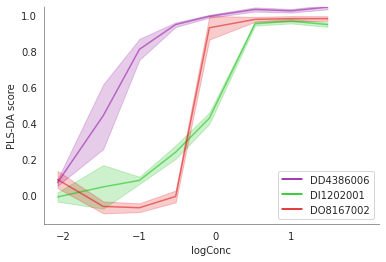

In [14]:
List0 = ['DD4386006', 'DO8167002', 'DI1202001'] #remdesivir, nirmatrelvir, and GC376
Lists = [List0]

for i, l in enumerate(Lists):

    test = PLS_pred_all[PLS_pred_all['batch_id'].isin(l)].copy()
    test.sort_values(['batch_id', 'cmpd_conc'], inplace=True)
    test['logConc'] = np.log10(test[['cmpd_conc']])
    #display(test)

    values = np.linspace(0.1, 0.9, len(list(set(test.batch_id))))
    colors = cm.nipy_spectral(values)

    fig = plt.figure(figsize = (6,4))

    ax = fig.add_subplot(111) 
    ax.set_xlabel('logConc', fontsize = 10)
    ax.set_ylabel('PLS-DA score', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    ax = sns.lineplot(x="logConc", y="PLS_pred",
                 hue="batch_id", palette = colors, alpha = 0.5,
                 data=test)
    ax.set_xlim(None, ax.get_xlim()[1] + 0.5)
    ax.set_ylim(None, 1.05)
    ax.set_xticks([-2, -1,  0, 1])
    ax.set_facecolor('w') 
    ax.legend(frameon=True, markerscale=1, fontsize=10, loc = 4)
    #ax.get_legend().remove()
    #plt.subplots_adjust(top=0.85, wspace=0.1, hspace=0, right = 1)
    #fig.suptitle('{}'.format(project), fontsize = 12)
    fig.savefig(f'{OutputDir}/PLS-DA_list{i}.png',  dpi=150, bbox_inches='tight')
    plt.show()

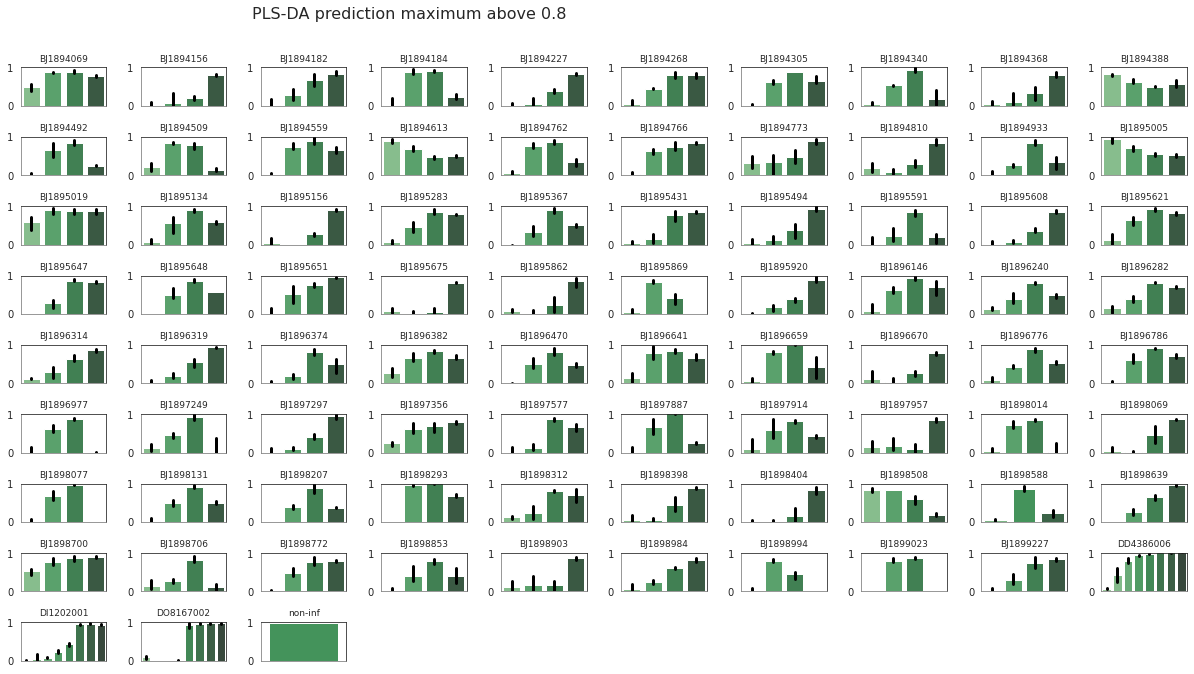

83

In [15]:
fig = plt.figure(figsize = (18,14))
fig.suptitle(f'PLS-DA prediction maximum above 0.8', fontsize = 16, x=0.3)
sp = 1
nrrow =12
nrcol = 10
counter= 0
CompoundList = sorted(list(set(PLS_pred_all.batch_id)))
for c in CompoundList[:]:
    dfOneCompound = PLS_pred_all.loc[(PLS_pred_all['batch_id'] == c)].copy()
    ConcList = sorted(list(set(dfOneCompound['cmpd_conc'])))
    if len(ConcList) > 0: # can be changed to select only multidose compounds
        groupbyConc=dfOneCompound.groupby('cmpd_conc').mean(numeric_only=True)
        if groupbyConc.PLS_pred.max() > 0.8:
            #print(f'{c}, {dfOneCompound.PLS_pred.max()}')
            counter += 1
            ax = fig.add_subplot(nrrow, nrcol, sp) 
            ax = sns.barplot(x="cmpd_conc", y="PLS_pred", data=dfOneCompound, palette="Greens_d",
                         alpha=1, errcolor='black', errwidth=3)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('grey')
            ax.spines['left'].set_color('grey')
            ax.set_ylim([0, 1.01])
            ax.set_title('{}'.format(c), fontsize = 9, x=0.5)
            ax.set(xlabel=None)
            ax.set(ylabel=None)
            ax.axes.xaxis.set_ticklabels([])
            sp += 1
plt.subplots_adjust(top=0.92,  wspace=0.4,  hspace=0.8,  left =0.0)
           
fig.savefig(f'{OutputDir}/PLS-DA_predictions_80+.png',  dpi=150, bbox_inches='tight')
plt.show()            
counter

### Calculate Pearson's correlations

In [16]:
clip= float('inf') # cut-off?

dfGrouped = df.groupby(['comp_conc']).mean(numeric_only=True)
display(dfGrouped)
x = dfGrouped.iloc[:, 2:].copy()
x.clip(lower=-clip, upper=clip, inplace=True)
CorrMatrics = (x + np.random.rand(*x.shape) / 1).T.corr() # add some noise to give more importance to higher values?
CorrToNonInf = CorrMatrics[['non-inf_0.3']].copy()
CorrToNonInf['batch_id'] = CorrToNonInf.index.str.split('_').str[0]
CorrToNonInf['cmpd_conc'] = CorrToNonInf.index.str.split('_').str[1].astype(float)
CorrToNonInf.rename(columns = {'non-inf_0.3': 'CorrToUninf'}, inplace=True)

,cmpd_conc,Count_nuclei,AreaShape_Area_nuclei,AreaShape_BoundingBoxArea_nuclei,AreaShape_BoundingBoxMaximum_X_nuclei,AreaShape_BoundingBoxMaximum_Y_nuclei,AreaShape_BoundingBoxMinimum_X_nuclei,AreaShape_BoundingBoxMinimum_Y_nuclei,AreaShape_Center_X_nuclei,AreaShape_Center_Y_nuclei,...,RadialDistribution_ZernikePhase_illumSYTO_8_0_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_2_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_4_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_6_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_8_8_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_1_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_3_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_5_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_7_cytoplasm,RadialDistribution_ZernikePhase_illumSYTO_9_9_cytoplasm
comp_conc,,,,,,,,,,,,,,,,,,,,,
BJ1894043_0.3,0.300000,223.555556,-0.289185,-0.232662,0.022843,-0.087278,0.025474,-0.084738,0.026634,-0.085935,...,0.276181,0.102510,-0.231360,0.116641,-0.169366,0.412474,0.230994,-0.160178,0.230529,0.014358
BJ1894043_10.0,10.000000,265.814815,0.427271,0.153041,0.044413,0.062700,0.040500,0.058477,0.045157,0.059603,...,-1.098905,0.365011,-0.030794,0.348831,-0.078890,0.326927,0.021402,-0.291462,0.368931,0.190066
BJ1894043_3.333333,3.333333,236.000000,-0.317392,-0.394924,0.235238,0.049576,0.238209,0.058457,0.239839,0.053752,...,-0.510665,0.181536,-0.187122,-0.089872,-0.001095,-0.020194,-0.097691,-0.099139,0.495453,-0.022013
BJ1894043_30.0,30.000000,234.407407,0.606563,0.350717,-0.580603,-0.014540,-0.583864,-0.022612,-0.581057,-0.019952,...,-1.152594,0.094785,-0.000449,-0.063430,-0.126717,0.072000,0.519505,0.359013,-0.056988,-0.164409
BJ1894069_0.3,0.300000,258.296296,1.579458,1.313525,-0.440520,-0.235069,-0.461566,-0.253505,-0.449404,-0.244790,...,-1.074964,0.262582,-0.020004,-0.553826,-0.034562,0.065413,-0.002184,-0.206853,0.208496,0.170921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
[etop]_5.0,5.000000,174.494152,3.684106,4.141137,0.230102,0.047484,0.170995,-0.008722,0.202840,0.018680,...,-0.098490,-0.025336,-0.000519,-0.124640,-0.049958,-0.022288,-0.289073,0.333322,0.001786,0.045773
[fenb]_5.0,5.000000,127.445927,0.850792,0.022652,0.266252,-0.310037,0.272112,-0.300579,0.270790,-0.306227,...,-3.537622,0.043968,0.011387,0.062817,0.030010,0.016480,0.181612,0.095529,-0.228933,-0.045222
[flup]_5.0,5.000000,268.267982,0.353298,-0.206198,0.141194,-0.088258,0.142313,-0.086140,0.144340,-0.087796,...,-1.665160,0.059301,-0.149875,0.088874,0.079672,0.046046,0.043253,0.052371,-0.022684,0.030045


In [17]:
Results = pred_per_comp_conc_Mean.merge(CorrToNonInf, left_on = [ 'batch_id', 'cmpd_conc'], right_on = [ 'batch_id', 'cmpd_conc'])
Results.to_csv(f'{OutputDir}/Results.csv', sep=';', float_format='%.3f')
Results

,batch_id,pert_iname,cbkid,cmpd_conc,Count_nuclei_mean,PLS_pred_mean,CorrToUninf
0,BJ1894043,A-7,CBK289945,0.300000,223.555556,-0.106895,-0.442317
1,BJ1894043,A-7,CBK289945,3.333333,236.000000,0.099617,0.148428
2,BJ1894043,A-7,CBK289945,10.000000,265.814815,0.425138,0.740820
3,BJ1894043,A-7,CBK289945,30.000000,234.407407,0.496311,0.685033
4,BJ1894069,calpeptin,CBK040880,0.300000,258.296296,0.506472,0.871481
...,...,...,...,...,...,...,...
1289,[etop],Etoposide,[etop],5.000000,174.494152,-0.049891,-0.082748
1290,[fenb],Fenbendazole,[fenb],5.000000,127.445927,0.006182,-0.210368
1291,[flup],Fluphenazine,[flup],5.000000,268.267982,0.721956,0.845822
1292,[stau],Staurosporine,[stau],0.100000,15.709388,-0.037610,0.050482


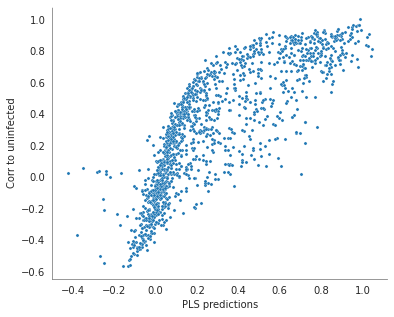

In [18]:
fig = plt.figure(figsize = (6,5))
ax = fig.add_subplot(111) 
ax.set_xlabel('PLS predictions', fontsize = 10)
ax.set_ylabel('Corr to uninfected', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
ax =sns.scatterplot(x='PLS_pred_mean', y='CorrToUninf',  
                  data=Results,
                   s=10, alpha = 1,  marker = 'o');
ax.set_facecolor('w')
plt.show()

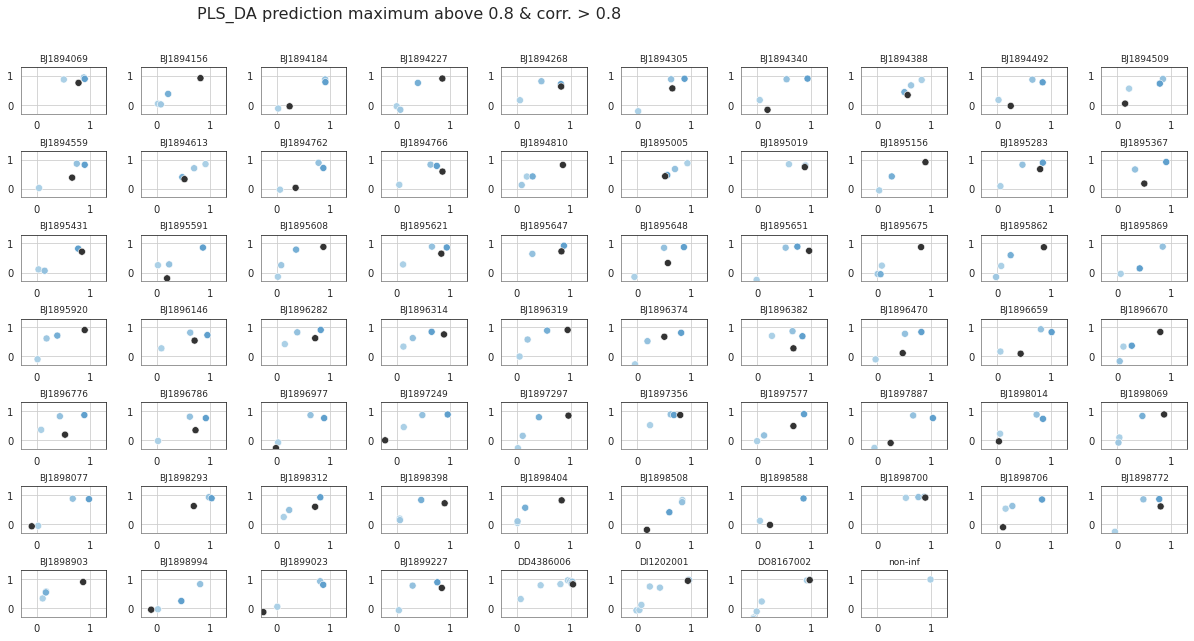

68

In [19]:
fig = plt.figure(figsize = (18,14))
fig.suptitle(f'PLS_DA prediction maximum above 0.8 & corr. > 0.8', fontsize = 16, x=0.3)
sp = 1
nrrow =10 
nrcol = 10
counter = 0
CompoundList = sorted(list(set(Results.batch_id)))
for c in CompoundList[:]:
    dfOneCompound = Results.loc[(Results['batch_id'] == c)].copy()
    ConcList = sorted(list(set(dfOneCompound['cmpd_conc'])))
    if len(ConcList) > 0: # can be changed to select only multidose compounds
        if (dfOneCompound.PLS_pred_mean.max() > 0.8) & (dfOneCompound.CorrToUninf.max() > 0.8):
            #print(f'{c}, {dfOneCompound.PLS_pred.max()}')
            counter += 1
            ax = fig.add_subplot(nrrow, nrcol, sp) 
            ax = sns.scatterplot(y="CorrToUninf", x="PLS_pred_mean", data=dfOneCompound, palette="Blues_d", hue = 'cmpd_conc',
                         s=50, alpha=1)
            ax.set_facecolor('w')
            ax.spines['bottom'].set_color('grey')
            ax.spines['left'].set_color('grey')
            ax.set_xlim([-0.3, 1.3])
            ax.set_ylim([-0.3, 1.3])
            ax.set_title('{}'.format(c), fontsize = 9, x=0.5)
            ax.set(xlabel=None)
            ax.set(ylabel=None)
            ax.grid(which='major', axis='both')
            ax.get_legend().remove()
            sp += 1

plt.subplots_adjust(top=0.92,  wspace=0.4,  hspace=0.8,  left =0.0)
           
fig.savefig(f'{OutputDir}/PLS-DA_pred_80+_corr80+.png',  dpi=150, bbox_inches='tight')
plt.show()            
counter